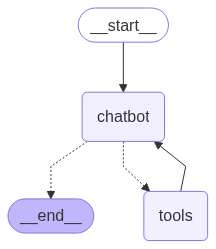

User:  北京今天的天气怎么样


Assistant: 
Assistant: {"query": "\u5317\u4eac\u5929\u6c14", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.weather.com.cn/weather15d/101010100.shtml", "title": "\u9884\u62a5- \u5317\u4eac - \u4e2d\u56fd\u5929\u6c14\u7f51", "content": "\u00e5\u008f\u00b0\u00e9\u00a3\u008e\u00e8\u00b7\u00af\u00e5\u00be\u0084 \u00e7\u00a9\u00ba\u00e9\u0097\u00b4\u00e5\u00a4\u00a9\u00e6\u00b0\u0094 \u00e5\u009b\u00be\u00e7\u0089\u0087 \u00e4\u00b8\u0093\u00e9\u00a2\u0098 \u00e7\u008e\u00af\u00e5\u00a2\u0083 \u00e6\u0097\u0085\u00e6\u00b8\u00b8 \u00e7\u00a2\u00b3\u00e4\u00b8\u00ad\u00e5\u0092\u008c \u00e6\u00b0\u0094\u00e8\u00b1\u00a1\u00e7\u00a7\u0091\u00e6\u0099\u00ae \u00e4\u00b8\u0080\u00e5\u00b8\u00a6\u00e4\u00b8\u0080\u00e8\u00b7\u00af \u00e4\u00ba\u00a7\u00e5\u0088\u009b\u00e5\u00b9\u00b3\u00e5\u008f\u00b0 \u00e7\u0083\u00ad\u00e9\u0097\u00a8\u00e5\u009f\u008e\u00e5\u00b8\u0082 \u00e7\u0083\u00ad\u00e9\u0097\u00a8\u00e6\u0099\u00af\u00e7\u0082\u00b9 \u00e

In [ ]:
import os
from dotenv import load_dotenv
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai.chat_models.base import ChatOpenAI
import json
from langchain_core.messages import ToolMessage

load_dotenv(override=True)

from langchain_tavily import TavilySearch


def createChatModel() -> ChatOpenAI:
    Amap_API_KEY = os.getenv("AMAP_API_KEY")
    model = ChatOpenAI(model="gpt4o", openai_api_key=Amap_API_KEY, base_url="https://pre-lmops.amap.com/open_api/v1")
    return model

def createSearchTool() -> TavilySearch:
    tool = TavilySearch(max_results=2)
    return tool
    
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

def route_tools(state: State,):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

graph_builder = StateGraph(State)
chat_model = createChatModel()
search_tool = createSearchTool()

tools = [search_tool]
chat_model_with_tools = chat_model.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [chat_model_with_tools.invoke(state["messages"])]}

# 添加一个名为 "chatbot" 的节点
graph_builder.add_node("chatbot", chatbot)

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# 添加一个 entry point, 告诉 graph 从哪里开始，这里从 "chatbot" 开始
graph_builder.add_edge(START, "chatbot")

# 添加一个 exit point，告诉 graph 到哪里结束，这里到 "chatbot" 结束
graph_builder.add_edge("chatbot", END)

# 无论何时，当 tools 被调用后，都回到 chatbot 重新询问
graph_builder.add_edge("tools", "chatbot")

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)

# 对图进行编译，得到一个 CompiledStateGraph 对象
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break